### EE 421/521 Image Processing - Spring 2021-22

## Lecture 6 - Color Theory

#### 24 March 2022

In this lecture, you will learn the following:

1. How to display RGB colors in the CIE XYZ color space
2. How to convert from additive RGB color space to subtractive CMY color space
3. How to convert between RGB and HSV color spaces
4. How to convert between RGB and YCbCr (YUV) color spaces
5. Fourier analysis of YUV color bands

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [2]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# mathematical calculations
import math

# DFT calculations
from scipy import fftpack as ft

# histogram calculation
from skimage import exposure

# signal processing operations
from scipy import signal
from scipy.linalg import circulant

### **Part 1:** Displaying RGB colors in the CIE XYZ color space


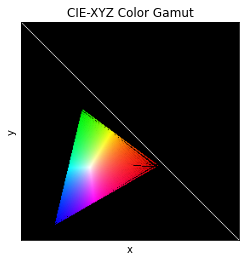

In [3]:
# 1. Construct and display the RGB triangle in the CIE XYZ Color Gamut

# set CIE XYZ image size
N = 256

# create an empty image to store the color gamut
img_cie_gamut = np.zeros((N,N,3))

# define transformation matrix
rgb2xyz = np.array([[0.449941,  0.316877,  0.181278],
                   [ 0.244768,  0.673364,  0.081868],
                   [ 0.025197,  0.141463,  0.906392]])

# go over all RGB colors (use steps of 4 to run faster)
step = 4
for R in range(0,256,step):
    for G in range(0,256,step):
        for B in range(0,256,step):
            
            if R == 0 and B == 0 and G == 0: continue
            
            RGB = np.array([R,G,B])
            XYZ = np.dot(rgb2xyz,RGB)
            
            X = XYZ[0]
            Y = XYZ[1]
            Z = XYZ[2]
            
            S = X+Y+Z
            x = X/S
            y = Y/S

            x_int = min(int(np.round(x*256,0)),255)
            y_int = min(int(np.round(y*256,0)),255)

            img_cie_gamut[y_int,x_int] = RGB
                        
# end of loops

# set type as byte
img_cie_gamut = img_cie_gamut.astype('uint8')

# draw a diagonal line on the image
for n in range(N):
    img_cie_gamut[n,N-n-1] = 255

# flip the y axis
img_cie_gamut[:,:,:] = img_cie_gamut[-1::-1,:,:]

# display CIE-XYZ color gamut for RGB primaries
plt.imshow(img_cie_gamut)
plt.title('CIE-XYZ Color Gamut')
plt.xticks([]), plt.yticks([])
plt.xlabel('x'), plt.ylabel('y')
plt.show()

### **Part 2:** Additive RGB Space vs. Subtractive CMY Space


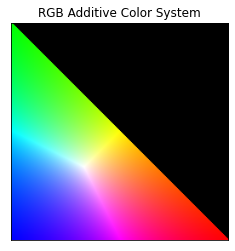

In [4]:
# 2.1 RGB color space and the additive color system

# set image size
N =256

# create an empty image to store the colors
img_RGB_colors = np.zeros((N,N,3),dtype=int)

# fill the color image

# vertical axis
for n in range(N):
    
    # horizontal axis
    for m in range(N-n):

        # find coefficient BG
        # coeff_BG = 1 means pure Green (n=N, m=0)
        coeff_BG = (float(n)/float(N))
        
        # find coefficient BR
        # coeff_BR = 1 means pure Red (n=0, m=N)
        coeff_BR = (float(m)/float(N-n))
        
        # calculate additive color
        val_G = coeff_BG
        val_R = (1.0-coeff_BG)*coeff_BR
        val_B = (1.0-coeff_BG)*(1.0-coeff_BR)
        
        # find largest
        val_max = max(val_R, val_G, val_B)
        
        # scale so that largest is 1
        val_G /= val_max
        val_R /= val_max
        val_B /= val_max
        
        # scale to 255
        color_G = int(255*val_G)
        color_R = int(255*val_R)
        color_B = int(255*val_B)

        # set image value
        img_RGB_colors[n,m] = np.array([color_R,color_G,color_B])
                 
# flip the y axis
img_RGB_colors[:,:,:] = img_RGB_colors[-1::-1,:,:]

# display color image
plt.imshow(img_RGB_colors)
plt.title('RGB Additive Color System')
plt.xticks([]), plt.yticks([])
plt.show()

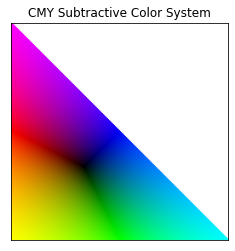

In [5]:
# 2.2 CMY color space and the subractive color system

# set image size
N =256

# create full white image to store the colors
img_CMY_colors = np.ones((N,N,3),dtype=int)
img_CMY_colors *= 255

# fill the color image
for n in range(N):
    for m in range(N-n):

        # find coefficient BG
        coeff_BG = (float(n)/float(N))
        # find coefficient BR
        coeff_BR = (float(m)/float(N-n))
        
        # calculate subtractive color
        val_G = coeff_BG
        val_R = (1.0-coeff_BG)*coeff_BR
        val_B = (1.0-coeff_BG)*(1.0-coeff_BR)
        
        # find largest
        val_max = max(val_R, val_G, val_B)
        
        # scale so that largest is 1
        val_G /= val_max
        val_R /= val_max
        val_B /= val_max
        
        # scale to 255
        color_G = int(255*val_G)
        color_R = int(255*val_R)
        color_B = int(255*val_B)

        # set image value by subtracting from white
        # note the subtraction sign below!!!
        img_CMY_colors[n,m] -= np.array([color_R,color_G,color_B])
                 
# flip the y axis
img_CMY_colors[:,:,:] = img_CMY_colors[-1::-1,:,:]

# display color image
plt.imshow(img_CMY_colors)
plt.title('CMY Subtractive Color System')
plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
# my function to convert from RGB to CMY

def my_rgb2cmy(imgRGB):
    
    height, width, ndim = imgRGB.shape
    assert ndim == 3

    # define RGB to CMY conversion table
    rgb2cmy = np.array([[-1,  0,  0, 1],
                       [  0, -1,  0, 1],
                       [  0,  0, -1, 1]])
    
    # create an image with 4 colors
    imgRGB4 = np.zeros((height,width,4))
    
    # first 3 colors are the original image data
    imgRGB4[:,:,:3] = imgRGB
    # 4th color is 255 to implement subtraction from white!!!
    imgRGB4[:,:,3] = 255
    
    imgCMY = np.dot(imgRGB4, np.transpose(rgb2cmy))
    imgCMY = imgCMY.astype('uint8')

    return imgCMY

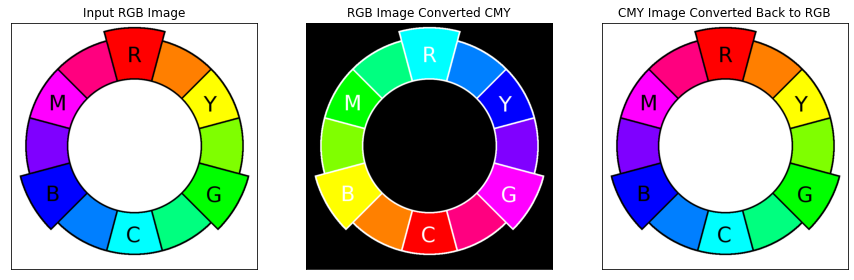

In [7]:
# 2.3 Conversion from RGB to CMY

#set image folder
image_folder = r'C:\Users\Metin\Desktop\EE421\Week6'

# read input image 
image_file = r'/rgb_color_wheel.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

# convert from RGB to CMY
imgCMY = my_rgb2cmy(imgRGB)

# back conversion function is the same as the conversion function!
imgRGB_fromCMY = my_rgb2cmy(imgCMY)

# display RGB and HSV images
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(imgRGB)
plt.title('Input RGB Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(imgCMY)
plt.title('RGB Image Converted CMY')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(imgRGB_fromCMY)
plt.title('CMY Image Converted Back to RGB')
plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

### **Part 3:** Conversion between RGB and HSV Color Spaces


In [8]:
# my function to convert from RGB to HSV

def my_RGB2HSV(imgRGB):
    
    N, M, D = imgRGB.shape
    
    assert N > 0
    assert M > 0
    assert D == 3
    
    imgHSV = np.zeros((N,M,3), dtype=float)
    imgHue = np.zeros((N,M), dtype=int)
    imgSat = np.zeros((N,M), dtype='uint8')
    imgVal = np.zeros((N,M), dtype='uint8')

    for n in range(N):
        for m in range(M):
            
            # get pixel color
            val = imgRGB[n,m]  
            R = int(val[0])
            G = int(val[1])
            B = int(val[2])

            # obtain Value
            V = max(R,G,B)
            
            # find minimum value
            Min_val = min(R,G,B)
            
            # find difference
            Diff_val = V - Min_val
            
            # obtain Saturation
            if V == 0:
                S = 0.0
            else:
                S = float(V-Min_val)/float(V)
                
            # obtain Hue
            if Diff_val == 0:
                H = 0.0
            else:
                if V == R:
                    H = 60.0 + 60.0*float(G-B)/float(Diff_val)

                elif V == G:
                    H = 180.0 + 60.0*float(B-R)/float(Diff_val)

                else:
                    H = 300.0 + 60.0*float(R-G)/float(Diff_val)
                
            # set HSV image value
            imgHSV[n,m] = np.array([H,S,float(V)])
            
            # hue image (between 0 and 360)
            imgHue[n,m] = int(round(H,0))
            
            # saturation image (scale to 100)
            imgSat[n,m] = int(round(S*100,0))
            
            # value image (between 0 and 255)
            imgVal[n,m] = V
                
    return imgHSV, imgHue, imgSat, imgVal

# end of my function

In [9]:
# 3.1 Read an image and convert to HSV

# set image folder
image_folder = r'/Users/tanjuerdem/EE421521_2022/images'

# read input image 
#image_file = r'/baboon.png'
image_file = r'/peppers.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

# convert to HSV
imgHSV, imgHue, imgSat, imgVal = my_RGB2HSV(imgRGB) 

# calculate the histogram of HSV bands
hist_H, bins = exposure.histogram(imgHue, source_range='image')
hist_S, bins = exposure.histogram(imgSat, source_range='dtype')
hist_V, bins = exposure.histogram(imgVal, source_range='dtype')

# original image and histrogram plot of Hue
plt.imshow(imgRGB)
plt.title('Original RGB Image')
plt.show()

# display HSV histogram data
plt.figure(figsize=(15,5))
plt.subplot(131), plt.plot(hist_H, color = 'b')
plt.xlim([0,360])
plt.title('Histogram of Hue')
plt.subplot(132), plt.plot(hist_S, color = 'b')
plt.xlim([0,100])
plt.title('Histogram of Saturation')
plt.subplot(133), plt.plot(hist_V, color = 'b')
plt.xlim([0,256])
plt.title('Histogram of Value')
plt.show()
plt.close()

# display HSV image
# auto-stretch to 0-255 range for display
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(imgHSV[:,:,0], cmap='gray')
plt.title('Hue')
plt.subplot(132), plt.imshow(imgHSV[:,:,1], cmap='gray')
plt.title('Saturation')
plt.subplot(133), plt.imshow(imgHSV[:,:,2], cmap='gray')
plt.title('Value')
plt.show()
plt.close()

FileNotFoundError: No such file: 'C:\Users\tanjuerdem\EE421521_2022\images\peppers.png'

In [ ]:
# my function to convert from HSV to RGB

def my_HSV2RGB(imgHSV):
    
    N, M, D = imgHSV.shape
    
    assert N > 0
    assert M > 0
    assert D == 3

    imgRGB = np.zeros((N,M,3), dtype='uint8')
    
    for n in range(N):
        for m in range(M):
            
            # get pixel HSV value
            val = imgHSV[n,m]  
            H = val[0]
            S = val[1]
            V = val[2]
            
            if V != 0.0:
                Min_val = V - S*V
            else:
                Min_val = 0.0
                
            if H >= 0.0 and H < 120.0:
                R = V
                if H < 60.0:
                    G = Min_val
                    B = G - (H-60.0)*(V-Min_val)/60.0
                else:
                    B = Min_val
                    G = B + (H-60.0)*(V-Min_val)/60.0
                    
            elif H >= 120.0 and H < 240.0:
                G = V
                if H < 180.0:
                    B = Min_val
                    R = B - (H-180.0)*(V-Min_val)/60.0
                else:
                    R = Min_val
                    B = R + (H-180.0)*(V-Min_val)/60.0

            else:
                B = V
                if H < 300.0:
                    R = Min_val
                    G = R - (H-300.0)*(V-Min_val)/60.0
                else:
                    G = Min_val
                    R = G + (H-300.0)*(V-Min_val)/60.0
                
            # integer values
            R_int = min(max(int(round(R,0)),0),255)
            G_int = min(max(int(round(G,0)),0),255)
            B_int = min(max(int(round(B,0)),0),255)
            
            # set RGB image value
            imgRGB[n,m] = np.array([R_int,G_int,B_int])
    
    return imgRGB

# end of my function

In [ ]:
# 3.2 Convert HSV space back to RGB space

imgRGB_back = my_HSV2RGB(imgHSV) 

# display orginal and HSV-then-RGB-back converted image
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(imgRGB)
plt.title('Original Image')
plt.subplot(122), plt.imshow(imgRGB_back)
plt.title('HSV-then-RGB Converted Image')
plt.show()
plt.close()

In [ ]:
# 3.3 The Effect of Setting Saturation to 1

imgHSV_S1 = imgHSV.copy()
imgHSV_S1[:,:,1] = 1.0

imgRGB_S1 = my_HSV2RGB(imgHSV_S1) 

# display orginal and HSV converted image
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(imgRGB)
plt.title('Original Image')
plt.subplot(122), plt.imshow(imgRGB_S1)
plt.title('HSV Saturation Set to 1')
plt.show()
plt.close()

In [ ]:
# 3.4 The Effect of Setting Value to 255

imgHSV_V255 = imgHSV.copy()
imgHSV_V255[:,:,2] = 255.0

imgRGB_V255 = my_HSV2RGB(imgHSV_V255) 

# display orginal and HSV converted image
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(imgRGB)
plt.title('Original Image')
plt.subplot(122), plt.imshow(imgRGB_V255)
plt.title('HSV Value Set to 255')
plt.show()
plt.close()

In [ ]:
# 3.5 The Effect of Setting Value to 255 & Saturation to 1

# Just the Hue!!!

imgHSV_S1_V255 = imgHSV.copy()
imgHSV_S1_V255[:,:,1] = 1.0
imgHSV_S1_V255[:,:,2] = 255.0

imgRGB_S1_V255 = my_HSV2RGB(imgHSV_S1_V255) 

# compare all results
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(imgRGB)
plt.title('Original Image')
plt.subplot(222), plt.imshow(imgRGB_S1)
plt.title('HSV Saturation Set to 1')
plt.subplot(223), plt.imshow(imgRGB_V255)
plt.title('HSV Value Set to 255')
plt.subplot(224), plt.imshow(imgRGB_S1_V255)
plt.title('HSV Saturation Set to 1 & Value Set to 255')
plt.show()
plt.close()

### **Part 4:** Conversion between RGB and YUV Color Spaces


In [ ]:
# my function to convert from RGB to YUV

def my_RGB2YUV(imgRGB):
    
    N, M, D = imgRGB.shape
    
    assert N > 0
    assert M > 0
    assert D == 3
    
    # RGB to YUV conversion matrix    
    rgb2yuv = np.array([[0.299,    0.587,    0.114   ],
                       [-0.168736, -0.331264,  0.5   ],
                       [ 0.5,   -0.418688, -0.081312]])
        
    # convert from RGB to YUV
    imgYUV = np.dot(imgRGB, np.transpose(rgb2yuv))
    
    # add 128 to U and V bands
    imgYUV[:,:,1] += 128.0
    imgYUV[:,:,2] += 128.0
    
    return imgYUV

# end of my function

In [ ]:
# 4.1 Conversion from RGB to YUV

# set image folder
image_folder_new = r'/Users/tanjuerdem/EE421521_2022/images'

# read input image 
image_file_new = r'/peppers.png' #lena, fruits
image_path_new = image_folder_new + image_file_new
imgRGB_new = io.imread(image_path_new)

imgYUV = my_RGB2YUV(imgRGB_new) 

# display original & YUV image
# auto-stretch to 0-255 range for display
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(imgRGB_new)
plt.title('Input RGB Image')
plt.subplot(222), plt.imshow(imgYUV[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.title('Luminance (Y)')
plt.subplot(223), plt.imshow(imgYUV[:,:,1], cmap='gray', vmin=0, vmax=255)
plt.title('Chrominance-B (U)')
plt.subplot(224), plt.imshow(imgYUV[:,:,2], cmap='gray', vmin=0, vmax=255)
plt.title('Chrominance-R (V)')
plt.show()
plt.close()

In [ ]:
# my function to convert from YUV to RGB

def my_YUV2RGB(imgYUV):
    
    N, M, D = imgYUV.shape
    
    assert N > 0
    assert M > 0
    assert D == 3
    
    # YUV to RGB conversion matrix
    yuv2rgb = np.array([[1.0,  0.0,       1.402   ],
                       [ 1.0, -0.344136, -0.714136],
                       [ 1.0,  1.772,     0.0    ]])
    
    # subtract 128 from U and V bands
    imgYUV_new = imgYUV.copy()
    imgYUV_new[:,:,1] -= 128.0
    imgYUV_new[:,:,2] -= 128.0

    # convert from YUV to RGB
    imgRGB = np.dot(imgYUV_new, np.transpose(yuv2rgb))
    
    imgRGB = np.round(imgRGB, 0)
    imgRGB = np.minimum(imgRGB, 255)
    imgRGB = np.maximum(imgRGB, 0)
    imgRGB = imgRGB.astype('uint8')
 
    return imgRGB

# end of my function

In [ ]:
# 4.2 Conversion from YUV back to RGB

imgRGB_fromYUV = my_YUV2RGB(imgYUV) 

# display RGB image converted back from YUV
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(imgRGB_new)
plt.title('Original Image')
plt.subplot(122), plt.imshow(imgRGB_fromYUV)
plt.title('RGB Image Converted Back from YUV')
plt.show()
plt.close()

In [ ]:
# display RGB & YUV color bands together

x_R = imgRGB_new[:,:,0]
x_G = imgRGB_new[:,:,1]
x_B = imgRGB_new[:,:,2]

x_Y = imgYUV[:,:,0]
x_U = imgYUV[:,:,1]
x_V = imgYUV[:,:,2]

# apply no stretching
plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(x_R, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('R')
plt.subplot(232), plt.imshow(x_G, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('G')
plt.subplot(233), plt.imshow(x_B, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('B') 
plt.subplot(234), plt.imshow(x_Y, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('Luminance (Y)')
plt.subplot(235), plt.imshow(x_U, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('Chrominance-B (U)')
plt.subplot(236), plt.imshow(x_V, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([]), plt.title('Chrominance-R (V)')
plt.show()
plt.close()

### **Part 5:** Fourier Analysis of YUV Bands


In [ ]:
# my function to multiply an image with (-1)^(i+j) 
# so that the origin of its DFT is displayed at the center

def my_img_shift(img):
    
    height, width = img.shape
    assert height%2 == 0 and width%2 == 0
    
    img_shift = img.copy() + 0.0

    for i in range(height):
        for j in range(width):
            if (i+j)%2 == 1:
                img_shift[i,j] *= -1.0
                
    return img_shift

# end of function

In [ ]:
# my function to obtain a display-friendly version of 2-D DFT of an image
# (used for displaying DFT magnitude, DFT real part, and DFT imaginary part)

def my_log_display(X_orig):
    
    X = X_orig.copy()
    
    shapeX = X.shape
    X = X.reshape(-1)

    for i in range(X.size):
        if X[i] < 0:
            # this is needed for real and imaginary parts
            X[i] = - np.log(1-X[i])
        else:
            # magnitude is always non-negative
            X[i] = np.log(1+X[i])
            
    return X.reshape(shapeX)

# end of function  

In [ ]:
# 5.1 Calculate and plot the DFT of the YUV bands

height, width, dim = imgYUV.shape

# multiply the image with (-1)^(i+j) before DFT so that DFT origin is displayed at the center
x_Y_shift = my_img_shift(x_Y)
x_U_shift = my_img_shift(x_U)
x_V_shift = my_img_shift(x_V)

# calculate the 2-D DFT via SciPy's 2-D DFT function
X_Y_shift = ft.fft2(x_Y_shift)
X_U_shift = ft.fft2(x_U_shift)
X_V_shift = ft.fft2(x_V_shift)

# DFT magnitude 
X_Y_mag = np.abs(X_Y_shift)
X_U_mag = np.abs(X_U_shift)
X_V_mag = np.abs(X_V_shift)

# get a display friendly version for magnitude
X_Y_mag_pr = my_log_display(X_Y_mag)
X_U_mag_pr = my_log_display(X_U_mag)
X_V_mag_pr = my_log_display(X_V_mag)

# extract the center line 
X_Y_center = X_Y_mag_pr[height//2,:]
X_U_center = X_U_mag_pr[height//2,:]
X_V_center = X_V_mag_pr[height//2,:]

# smooth the center line
smt_size = 5
smt_filter = np.ones((smt_size,))
smt_filter /= smt_filter.sum()
X_Y_center_smooth = signal.convolve(X_Y_center, smt_filter, 'same')
X_U_center_smooth = signal.convolve(X_U_center, smt_filter, 'same')
X_V_center_smooth = signal.convolve(X_V_center, smt_filter, 'same')

plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(X_Y_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude Y')
plt.subplot(232), plt.imshow(X_U_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude U')
plt.subplot(233), plt.imshow(X_V_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude V')
plt.subplot(234), plt.ylim((8, 15)), plt.plot(X_Y_center_smooth)
plt.title('Horizontal Cross Section Y')
plt.subplot(235), plt.ylim((8, 15)), plt.plot(X_U_center_smooth)
plt.title('Horizontal Cross Section U')
plt.subplot(236), plt.ylim((8, 15)), plt.plot(X_V_center_smooth)
plt.title('Horizontal Cross Section V')
plt.show()
plt.close()

In [ ]:
# 5.2 Calculate and plot the DFT of the RGB bands

height, width, dim = imgRGB_new.shape

# multiply the image with (-1)^(i+j) before DFT so that DFT origin is displayed at the center
x_R_shift = my_img_shift(x_R)
x_G_shift = my_img_shift(x_G)
x_B_shift = my_img_shift(x_B)

# calculate the 2-D DFT via SciPy's 2-D DFT function
X_R_shift = ft.fft2(x_R_shift)
X_G_shift = ft.fft2(x_G_shift)
X_B_shift = ft.fft2(x_B_shift)

# DFT magnitude 
X_R_mag = np.abs(X_R_shift)
X_G_mag = np.abs(X_G_shift)
X_B_mag = np.abs(X_B_shift)

# get a display friendly version for magnitude
X_R_mag_pr = my_log_display(X_R_mag)
X_G_mag_pr = my_log_display(X_G_mag)
X_B_mag_pr = my_log_display(X_B_mag)

# extract the center line 
X_R_center = X_R_mag_pr[height//2,:]
X_G_center = X_G_mag_pr[height//2,:]
X_B_center = X_B_mag_pr[height//2,:]

# smooth the center line
smt_size = 5
smt_filter = np.ones((smt_size,))
smt_filter /= smt_filter.sum()
X_R_center_smooth = signal.convolve(X_R_center, smt_filter, 'same')
X_G_center_smooth = signal.convolve(X_G_center, smt_filter, 'same')
X_B_center_smooth = signal.convolve(X_B_center, smt_filter, 'same')

plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(X_R_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude R')
plt.subplot(232), plt.imshow(X_G_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude G')
plt.subplot(233), plt.imshow(X_B_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude B')
plt.subplot(234), plt.ylim((8, 15)), plt.plot(X_R_center_smooth)
plt.title('Horizontal Cross Section R')
plt.subplot(235), plt.ylim((8, 15)), plt.plot(X_G_center_smooth)
plt.title('Horizontal Cross Section G')
plt.subplot(236), plt.ylim((8, 15)), plt.plot(X_B_center_smooth)
plt.title('Horizontal Cross Section B')
plt.show()
plt.close()

In [ ]:
# calculate the standard deviation of pixel values in an image band

def my_std(img):
    
    # single band image only
    assert img.ndim == 2
    
    # calculate the average value
    ave_val = img.sum()/float(img.size)
    
    # calculate and return the standard deviation
    return math.sqrt(((img-ave_val)**2).sum() / img.size)

    
# end of function

In [ ]:
# 5.5 Compare the Fourier bandwidths and standard deviations of RGB and YUV bands

plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(X_R_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude R (std = {:.2f})'.format(my_std(x_R)))
plt.subplot(232), plt.imshow(X_G_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude G (std = {:.2f})'.format(my_std(x_G)))
plt.subplot(233), plt.imshow(X_B_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude B (std = {:.2f})'.format(my_std(x_B)))
plt.subplot(234), plt.imshow(X_Y_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude Y (std = {:.2f})'.format(my_std(x_Y)))
plt.subplot(235), plt.imshow(X_U_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude U (std = {:.2f})'.format(my_std(x_U)))
plt.subplot(236), plt.imshow(X_V_mag_pr, cmap='gray', vmin=8, vmax=15)
plt.title('DFT Magnitude V (std = {:.2f})'.format(my_std(x_V)))
plt.show()
plt.close()